In [ ]:
pip install yfinance

In [ ]:
pip install kaggle

In [ ]:
pip install nsepy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm
from pathlib import Path
import matplotlib.image as mpimg
import random
import shutil

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/RSM8521_DeepLearning')

ValueError: Mountpoint must be in a directory that exists

# Collect Data

In [ ]:
data_df = pd.read_csv('data_df.csv')

In [ ]:
SP500 = pd.read_csv('constituents.csv')
SP500

In [ ]:
SP500_ticker_list = list(SP500['Symbol'])
SP500_ticker_list

In [ ]:
data_df = pd.DataFrame()

for ticker in tqdm(SP500_ticker_list):
    try:
        tickerData = yf.Ticker(ticker)
        tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2019-12-31').reset_index()
        tickerDf = tickerDf[['Date','Open','High','Low','Close','Volume']]
        tickerDf['ticker'] = ticker

        data_df = pd.concat([data_df, tickerDf], axis = 0)
    except:
        continue

data_df

100%|██████████| 503/503 [01:32<00:00,  5.42it/s]


,Date,Open,High,Low,Close,Volume,ticker
0,2010-01-04 00:00:00-05:00,40.869485,41.046558,40.662898,40.835056,3640265.0,MMM
1,2010-01-05 00:00:00-05:00,40.726839,40.938345,40.185783,40.579281,3405012.0,MMM
2,2010-01-06 00:00:00-05:00,41.258047,41.612192,41.076055,41.154751,6301126.0,MMM
3,2010-01-07 00:00:00-05:00,40.982593,41.199018,40.392351,41.184261,5346240.0,MMM
4,2010-01-08 00:00:00-05:00,41.164598,41.474476,40.972768,41.474476,4073337.0,MMM
...,...,...,...,...,...,...,...
1735,2019-12-23 00:00:00-05:00,128.439146,128.777874,127.161619,128.110077,1632300.0,ZTS
1736,2019-12-24 00:00:00-05:00,127.955222,128.797219,127.064816,128.642365,442500.0,ZTS
1737,2019-12-26 00:00:00-05:00,128.903725,128.903725,128.061728,128.748871,929400.0,ZTS
1738,2019-12-27 00:00:00-05:00,129.106959,129.184386,128.119795,128.961792,1296100.0,ZTS


In [ ]:
data_df['Date'] = data_df['Date'].dt.strftime('%Y-%m-%d')
data_df.to_csv('data_df.csv')

# Prepare Candlestick Charts

In [ ]:
from datetime import date
from nsepy import get_history

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    """
    Plots a candlestick chart using quantopian pricing data.

    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'

    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['open_price']
    close_price = pricing['close_price']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)

    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]},figsize=(7,7))
    else:
        fig, ax1 = plt.subplots(1, 1)
    if title:
        ax1.set_title(title)
    fig.tight_layout()

    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x , low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(True)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    ax1.set_yticklabels([])

    # Set X axis tick labels
    for indicator in technicals:
        ax1.plot(x, indicator)

    plt.close(fig)

    return fig

In [ ]:
data_df.rename(columns={'Open': 'open_price',
                      'Close': 'close_price',
                      'High': 'high',
                      'Low': 'low',
                      'Volume': 'volume'}, inplace=True)

In [ ]:
fraction_movement = 0.01
count = 0

for ticker in list(data_df['ticker'].unique()):
    if count < 10000:
        df = data_df[data_df['ticker']==ticker].reset_index(drop=True)

        for i in range(21, len(df), 25):
            try:
                n = 5
                if df.loc[i,'close_price'] - df.loc[i+n,'close_price'] >= fraction_movement * df.loc[i,'close_price']:
                    df.loc[i,'Decision'] = 'Sell'
                    if i >= 20 :
                        sliced_df = df[i-20:i].reset_index(drop=True)
                        fig = plot_candles(sliced_df,volume_bars=False)
                        fig.savefig('Candle_Data/Sell/{0}{1}.png'.format(df['ticker'][i],i),dpi=70)
                        print('sell', count)
                        count += 1
                    continue
                elif df.loc[i+n,'close_price'] - df.loc[i,'close_price'] >= fraction_movement*df.loc[i,'close_price']:
                    df.loc[i,'Decision'] = 'Buy'
                    if i > 20:
                        sliced_df = df[i-20:i].reset_index(drop=True)
                        fig=plot_candles(sliced_df,volume_bars=False)
                        fig.savefig('Candle_Data/Buy/{0}{1}.png'.format(df['ticker'][i],i),dpi=70)
                        print('buy', count)
                        count += 1
                    continue
                else:
                    df.loc[i,'Decision']= 'Hold'
                    sliced_df = df[i-20:i].reset_index(drop=True)
                    fig=plot_candles(sliced_df,volume_bars=False)
                    fig.savefig('Candle_Data/Hold/{0}{1}.png'.format(df['ticker'][i],i),dpi=70)
                    print('hold', count)
                    count += 1

            except:
                print(i, ticker)
                pass

    else:
        break

# Load Labeled Data

In [ ]:
path = Path('/content/drive/My Drive/RSM8521_DeepLearning/Candle_Data')
class_names = np.array(sorted([item.name for item in path.glob('*')]))
print(class_names)

['Buy' 'Hold' 'Sell']


In [ ]:
for dirpath , dir_num , file_num in os.walk("/content/drive/My Drive/RSM8521_DeepLearning/Candle_Data"):
  print(f"There are {len(dir_num)} directories and {len(file_num)} images in  ' {dirpath} ' ")

There are 3 directories and 0 images in  ' /content/drive/My Drive/RSM8521_DeepLearning/Candle_Data ' 
There are 0 directories and 3346 images in  ' /content/drive/My Drive/RSM8521_DeepLearning/Candle_Data/Hold ' 
There are 0 directories and 4744 images in  ' /content/drive/My Drive/RSM8521_DeepLearning/Candle_Data/Buy ' 
There are 0 directories and 3524 images in  ' /content/drive/My Drive/RSM8521_DeepLearning/Candle_Data/Sell ' 


In [ ]:
from sklearn.model_selection import train_test_split

def label_and_prepare_data(source_dir, destination_dir, train_size=0.8):
    labels = {'Buy': '1', 'Sell': '2', 'Hold': '0'}
    data = []

    # Ensure destination directory exists
    os.makedirs(destination_dir, exist_ok=True)

    # Walk through each directory in the source directory
    for dirpath, dirnames, filenames in os.walk(source_dir):
        for dirname in dirnames:
            if dirname in labels:
                files = os.listdir(os.path.join(dirpath, dirname))
                for file in files:
                    # Construct the source file path and new destination file path
                    src_file_path = os.path.join(dirpath, dirname, file)
                    new_filename = f"{labels[dirname]}_{file}"
                    dst_file_path = os.path.join(destination_dir, new_filename)

                    # Copy file to the new directory with the new name
                    shutil.copy(src_file_path, dst_file_path)
                    data.append(dst_file_path)

    # Split data into training and testing
    train_files, test_files = train_test_split(data, train_size=train_size, random_state=42)

    # Create training and testing directories
    train_dir = os.path.join(destination_dir, 'training')
    test_dir = os.path.join(destination_dir, 'testing')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Move files to their respective directories
    for file in train_files:
        shutil.move(file, train_dir)
    for file in test_files:
        shutil.move(file, test_dir)

    print(f"Training data: {len(train_files)} images")
    print(f"Testing data: {len(test_files)} images")

source_dir = "/content/drive/My Drive/RSM8521_DeepLearning/Candle_Data"
destination_dir = "/content/drive/My Drive/RSM8521_DeepLearning/Train_Test"
label_and_prepare_data(source_dir, destination_dir)

Training data: 9291 images
Testing data: 2323 images


In [ ]:
base_dir = '/content/drive/My Drive/RSM8521_DeepLearning/Candle_Data/training'

labels = ['0', '1', '2']
for label in labels:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

# Iterate through all files in the base directory
for filename in os.listdir(base_dir):
    if filename.endswith(".png"):
        label = filename[0]  # Get the first character of the filename as the label
        if label in labels:
            # Construct the source path and destination path
            src_path = os.path.join(base_dir, filename)
            dst_path = os.path.join(base_dir, label, filename)
            # Move the file to the corresponding label directory
            shutil.move(src_path, dst_path)
            print(f'Moved {filename} to {dst_path}')

In [ ]:
base_dir = '/content/drive/My Drive/RSM8521_DeepLearning/Candle_Data/testing'

labels = ['0', '1', '2']
for label in labels:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

# Iterate through all files in the base directory
for filename in os.listdir(base_dir):
    if filename.endswith(".png"):
        label = filename[0]  # Get the first character of the filename as the label
        if label in labels:
            # Construct the source path and destination path
            src_path = os.path.join(base_dir, filename)
            dst_path = os.path.join(base_dir, label, filename)
            # Move the file to the corresponding label directory
            shutil.move(src_path, dst_path)
            print(f'Moved {filename} to {dst_path}')

# Train Model

In [ ]:
train_dir = "/Users/weihao/Desktop/RSM8521_Deep_Learning/Final_Project/Train_Test/training"
test_dir = "/Users/weihao/Desktop/RSM8521_Deep_Learning/Final_Project/Train_Test/testing"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Create an instance of ImageDataGenerator with the necessary preprocessing
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

# Prepare data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from PIL import UnidentifiedImageError

class SafeImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, *args, **kwargs)
        return SafeDirectoryIterator(generator, self, directory, *args, **kwargs)

from tensorflow.keras.utils import Sequence
from PIL import UnidentifiedImageError
from IPython.display import display
from PIL import Image

class SafeDirectoryIterator(Sequence):
    def __init__(self, generator, image_data_generator, directory, *args, **kwargs):
        self.generator = generator
        self.directory = directory
        self.image_data_generator = image_data_generator
        self.filenames = generator.filenames
        self.args = args
        self.kwargs = kwargs

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        while True:
            try:
                data = self.generator[index]
                return data
            except UnidentifiedImageError as e:
                print(f"Skipping unreadable image at index {index}: {e}")
                bad_image = self.filenames[index]  # Retrieve the problematic file name
                full_path = os.path.join(self.directory, bad_image)
                print(f"File path: {full_path}")

                # Optionally, display the image (if you're in an IPython environment)
                try:
                    img = Image.open(full_path)
                    display(img)
                except Exception as display_e:
                    print(f"Could not display image: {display_e}")

                # You may want to delete or move the file, or just continue
                # os.remove(full_path)  # Caution: this will delete the file!
                # Instead of deleting, you can move the file to a 'bad_images' directory
                # bad_images_dir = 'path_to_bad_images_directory'
                # os.makedirs(bad_images_dir, exist_ok=True)
                # os.rename(full_path, os.path.join(bad_images_dir, os.path.basename(full_path)))

                index = (index + 1) % len(self)
            except Exception as e:
                print(f"An error occurred: {e}")
                index = (index + 1) % len(self)

# rest of your code remains the same


train_datagen = SafeImageDataGenerator(rescale=1./255)
test_datagen = SafeImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


/Users/weihao/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Found 5634 images belonging to 3 classes.
Found 2323 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

2024-04-21 12:52:12.865977: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-21 12:52:12.866016: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-21 12:52:12.866026: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-21 12:52:12.866062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-21 12:52:12.866092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Epoch 1/10


2024-04-21 12:52:17.421017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


165/177 [==========================>...] - ETA: 2s - loss: 1.1282 - accuracy: 0.3657Skipping unreadable image at index 39: cannot identify image file <_io.BytesIO object at 0x2da7eec50>
File path: /Users/weihao/Desktop/RSM8521_Deep_Learning/Final_Project/Train_Test/training/0/0_ABBV246.png


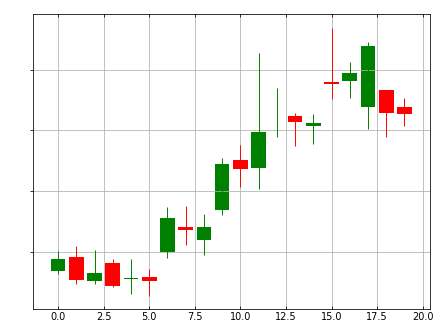

177/177 [==============================] - 46s 256ms/step - loss: 1.1252 - accuracy: 0.3708 - val_loss: 1.0984 - val_accuracy: 0.4115
Epoch 2/10
134/177 [=====================>........] - ETA: 7s - loss: 1.1075 - accuracy: 0.3746Skipping unreadable image at index 39: cannot identify image file <_io.BytesIO object at 0x370b4bba0>
File path: /Users/weihao/Desktop/RSM8521_Deep_Learning/Final_Project/Train_Test/training/0/0_ABBV246.png


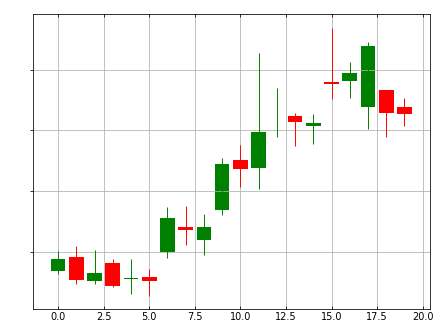

177/177 [==============================] - 45s 256ms/step - loss: 1.1067 - accuracy: 0.3763 - val_loss: 1.1038 - val_accuracy: 0.4115
Epoch 3/10
162/177 [==========================>...] - ETA: 2s - loss: 1.0953 - accuracy: 0.3956Skipping unreadable image at index 39: cannot identify image file <_io.BytesIO object at 0x2cd217ec0>
File path: /Users/weihao/Desktop/RSM8521_Deep_Learning/Final_Project/Train_Test/training/0/0_ABBV246.png


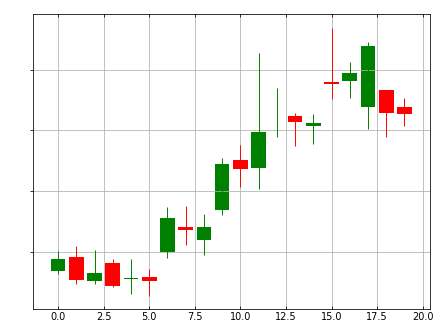

177/177 [==============================] - ETA: 0s - loss: 1.0959 - accuracy: 0.3940

KeyboardInterrupt: 

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10, validation_data=test_generator)

In [ ]:
model.save('ResNet1')
model.save('ResNet1.h5')

In [ ]:
results = model.evaluate(test_generator)
print("Test Loss, Test Accuracy:", results)

19/19 [==============================] - 5s 235ms/step - loss: 1.6830 - accuracy: 0.3349
Test Loss, Test Accuracy: [1.6829941272735596, 0.3349117636680603]


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the output
# test_generator.reset()  # Resetting the generator is important before making new predictions
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve the true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get the list of class labels

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
import tensorflow as tf

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2024-04-21 11:04:04.264978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-21 11:04:04.265073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-21 11:04:04.266111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-21 11:04:04.266132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Another Model

In [ ]:
pip install fastai

In [ ]:
from fastai.vision.all import *
from fastai.metrics import error_rate

In [ ]:
np.random.seed(42)
path  = "/Users/weihao/Desktop/RSM8521_Deep_Learning/Final_Project/Train_Test/training"
#data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2)

In [ ]:
from fastai.vision.all import *
import os
from PIL import Image

def is_valid_image(file_path):
    """Check if the image can be opened with PIL."""
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify that it is, in fact, an image
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image file {file_path}: {e}")
        return False

def get_image_files_filtered(path):
    """Retrieve image files ensuring all are valid."""
    files = get_image_files(path)
    return [f for f in files if is_valid_image(f)]
 # Change this to the path of your image data
data = ImageDataLoaders.from_name_func(
    path,
    get_image_files_filtered(path),
    valid_pct=0.2,
    label_func=parent_label,  # Assuming labels are folder names
    item_tfms=Resize(224)  # Example transformation; adjust as needed
)

Invalid image file /Users/weihao/Desktop/RSM8521_Deep_Learning/Final_Project/Train_Test/training/1/1_STZ1096.png: cannot identify image file '/Users/weihao/Desktop/RSM8521_Deep_Learning/Final_Project/Train_Test/training/1/1_STZ1096.png'


In [ ]:
data.show_batch(max_n = 20)

In [ ]:
learn = vision_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fine_tune(1,base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:57


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=6.309573450380412e-07)

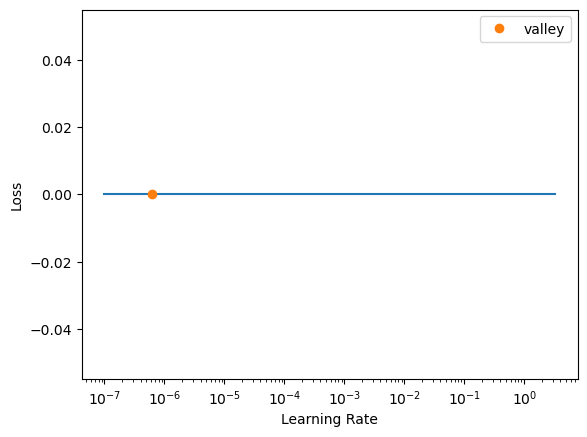

In [ ]:
learn.lr_find()

In [ ]:
idx=233
x,y = data.valid_ds[idx]

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])

AttributeError: one_item